# JuliaRun

#### JuliaCon 2017, Berkeley

# Make It Easy To Run and Deploy Julia At Scale

- code and package management
- autoscale (processes and VMs)
- dynamic node types (GPUs, spot instances, hi-memory, hi-cpu)
- get appropriate storage for our data

- application metrics
- log management

- authentication
- multi-tenancy

- simple and uniform API irrespective of deployment platforms

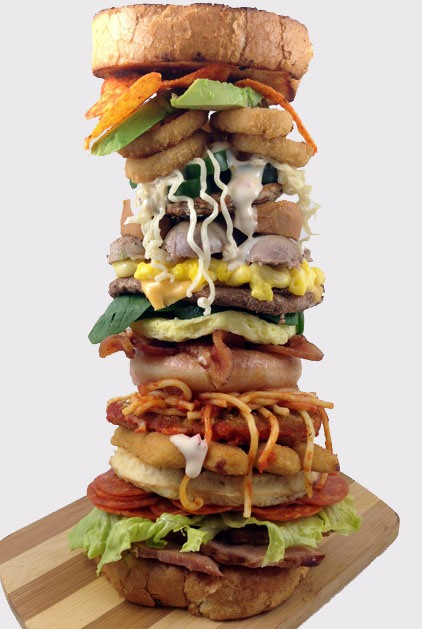

<center><small>Photo Courtesy of Dudefoods.com</small></center>

# Architecture

- Kubernetes (and Docker)
- A few other nice tools
- And JuliaRun

---
- Exposed via an easy Julia API
- Loose coupling => pluggable

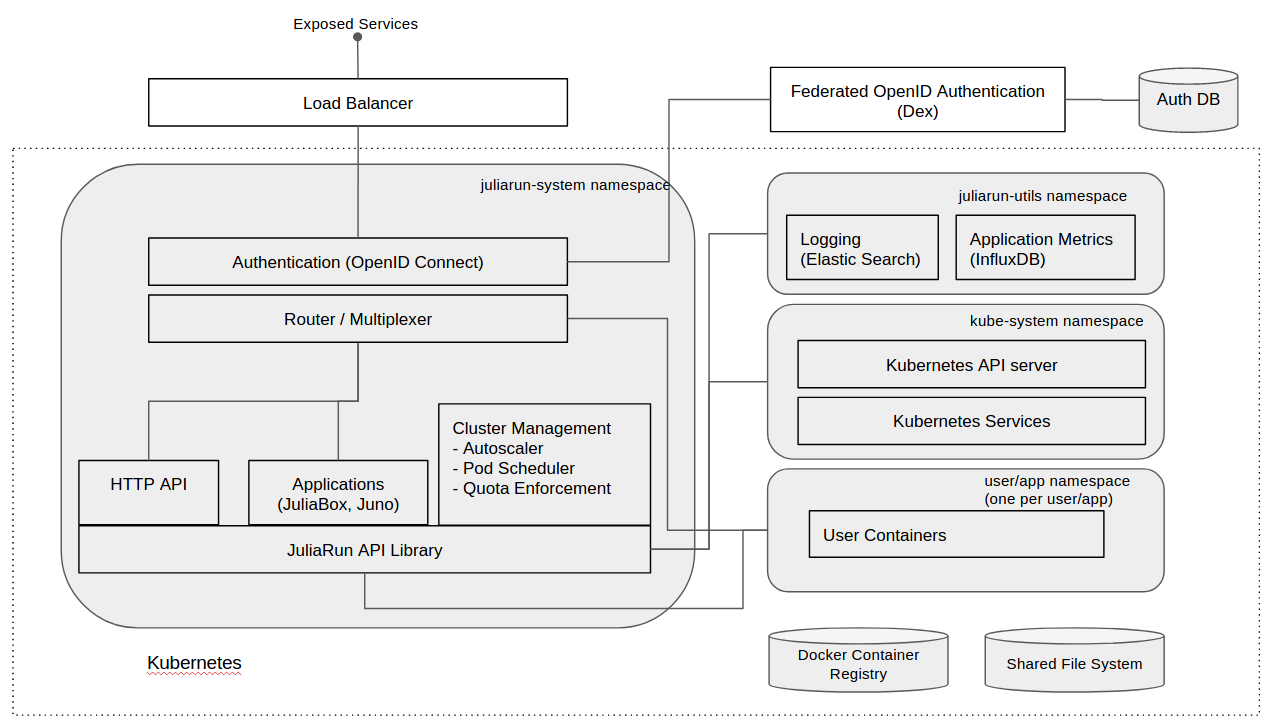

# Challenges and JuliaRun's Approach

# Containers, Packages, Code, Data

- Build images, push to repository, pre-warm nodes
- Install/update/precompile packages
- Easy access to your code, data, logs
- Choose the type of storage (SSD, Network, RAM)

---
- Builders for images and package bundles
    - Update specifications, fire up a builder
- Storage (for code, data, logs)
    - Declarative: define once, access by name / alias
    - File/Block storage
    - Mount file storage as drive on your laptop
    - RAM-disk, Host disk, Git repo

# Resource Management
- Provision (CPU, GPU, memory...)
- Within specified constraints
- As needed / Proactively
- Release after use
- Scheduling rules (co-locate, specify node type)

---
- cluster scaler
- scheduler
- fully customizable (in Julia)

# Log Management

- Logging is distributed
- Collect & assimilate globally
- Use at any granularity level

---
- stdout and stderr logged automatically
- JuliaRun APIs to
    - Filter / Stream / Search
    - During / After execution
- Powered by Elasticsearch

# Application / System Metrics

- Record Metrics
    - Name-Value pairs
        - e.g.: files processed, or pending queue
- Aggregate, Visualize, Plot

---
- JuliaRun APIs: application metrics
- Automatic: system metrics
- Visualize: Julia / Kibana / Grafana
- Alert on abnormal / extra-normal conditions
- Scale/Power applications up/down
- Powered by InfluxDB and Heapster

# Authentication, Authorization

- OpenID based authentication
    - Federation allows combining multiple authentication providers
- Authorization & Resource Allocation
    - Using Kubernetes
        - RBAC
        - Namespaces
        - Quotas

# Expose Services

- Expose HTTP based services
- Authenticate
- Authorize (via. Kubernetes Roles)
---
- Router / Multiplexer - A authenticating proxy
- APIs to register a service with Router
- Instantaneous (compared to creating a Kubernetes LoadBalancer Service)
- Passes credentials and authentication tokens to downstream app

# Cluster Autoscale

- Based on resource reservation (instead of system load)
- Via API
- Configurable headroom
    - Predictable
    - Better experience with interactive / critical workloads
    - Avoid waiting for cluster resources
- Select specific nodes while scaling down
    - Avoid interrupting critical processes
- On Microsoft Azure, Amazon AWS and Google GCP clouds

# Process Autoscale

- JuliaRun process autoscaler
    - Start Scaler as a task on JuliaRun specifying
        - job to scale
        - metrics to use
        - scaling logic
- Or use Kubernetes pod autoscaler
    - publish metrics
    - start pod autoscaler pointing to your metrics
- Easy Julia API for both

# Scheduler

- Co-locate Julia processes
- Work together with autoscaler to optimize number of nodes
- Allows plugging in custom Julia methods
- ~~Work closely with Julia applications~~
- ~~Under development~~

# APIs

In [3]:
using JuliaRun

In [4]:
# initialize a context for our cluster
ENV["JRUN_CONFIG"] = "/home/tan/.julia/v0.5/JuliaRun/cfg/config.json"
ctx = init()

# let's see what we have in the cluster
status(ctx; verbose=true)

21-Jun 17:21:35:INFO:root:Reading configuration from /home/tan/.julia/v0.5/JuliaRun/cfg/config.json
21-Jun 17:21:35:INFO:root:Compute cluster: default at http://localhost:8001/


Components
✓ scheduler
✓ controller-manager
✓ etcd-0

Pods waiting
  for scheduler: 0
  for free nodes: 0
  resource misfit: 0

Nodes (resource free pct)
  cpu gpu mem dsk pod name
✓  65   0  97   0  83 tanlt


true

In [5]:
# submit a job
job = JuliaBatch("helloworld", "/mnt/juliarun/helloworld/helloworld.jl", "juliarun")

submit(ctx, job)

21-Jun 17:21:43:INFO:root:starting helloworld...


In [6]:
# see all scheduled jobs
list(ctx)

1-element Array{JuliaRun.JRunJob,1}:
 JuliaBatch(helloworld)

In [7]:
# get status of the job
status(ctx, job)

created, 1 processes waiting

In [8]:
# tail a jobs stdin/stdout
tail(ctx; job=job)

21-Jun 17:21:49:INFO:root:tail helloworld


2017-06-22T00:11:47+00:00, helloworld-2rt8g, hello world!
2017-06-22T00:13:03+00:00, helloworld-ln5tk, hello world!
2017-06-22T00:17:34+00:00, helloworld-tqjdh, hello world!


In [9]:
status(ctx, job)

succeeded

In [10]:
# cleanup the job entry
delete!(ctx, job)

21-Jun 17:21:58:INFO:root:deleting helloworld ...
21-Jun 17:21:59:INFO:root:deleting Pod helloworld-n4xww ...


true

# Demos

# Process Autoscaler

In [11]:
# include some utility functions
include("procscaler.jl")

# start the message queue
queue = start_queue(ctx)

# start the queue workers
workers = JuliaParBatchWorkers("workers", "/mnt/juliarun/scaler/worker.jl", "juliarun";
    pkg_bundle="pkgdefault", nworkers=1, cpu="500m", memory="1Gi", restart="OnFailure")
submit(ctx, workers)

21-Jun 17:22:13:INFO:root:starting mq...
21-Jun 17:22:13:INFO:root:starting workers...
21-Jun 17:22:13:INFO:root:exposing service...
21-Jun 17:22:13:INFO:root:opening additional ports...
21-Jun 17:22:19:INFO:root:getting mq endpoint...
21-Jun 17:22:20:INFO:root:JuliaRun.MessageQ up at String["10.105.159.79","tanlt"]:[30011] for amqp
21-Jun 17:22:20:INFO:root:starting workers...
21-Jun 17:22:20:INFO:root:starting workers...


In [12]:
# setup an autoscaler
qmetric = WorkQueueMetric(QUEUE; virtualhost="/", host="localhost", 
    port=AMQP_PORT, auth_params=AMQPClient.DEFAULT_AUTH_PARAMS)
metric = BoundedMetric(AverageMetric(qmetric, WINDOW_SIZE), 1:10)
scaler = JobScaler(ctx, workers, metric, CHECK_INTERVAL)

# start it in the background
scalertask = @async run(scaler)

Task (runnable) @0x00007fac51081d50

In [18]:
# fire up some requests
@async publish_work()

Task (queued) @0x00007fac52f15600

21-Jun 17:28:05:INFO:root:changing scale of workers to 2


In [19]:
# and some more
@async publish_work()

Task (runnable) @0x00007fac531a4760

Done
Done


21-Jun 17:28:15:INFO:root:changing scale of workers to 3


In [20]:
# even more
@async publish_work()
# and then watch processes scale up initially and then back down

Task (queued) @0x00007fac526ad600

21-Jun 17:28:25:INFO:root:changing scale of workers to 5


Done


21-Jun 17:28:35:INFO:root:changing scale of workers to 6
21-Jun 17:28:45:INFO:root:changing scale of workers to 7
21-Jun 17:28:56:INFO:root:changing scale of workers to 8
21-Jun 17:29:06:INFO:root:changing scale of workers to 9
21-Jun 17:29:16:INFO:root:changing scale of workers to 10
21-Jun 17:31:07:INFO:root:changing scale of workers to 9
21-Jun 17:31:27:INFO:root:changing scale of workers to 8
21-Jun 17:31:37:INFO:root:changing scale of workers to 7
21-Jun 17:31:47:INFO:root:changing scale of workers to 6
21-Jun 17:31:57:INFO:root:changing scale of workers to 4
21-Jun 17:32:07:INFO:root:changing scale of workers to 3
21-Jun 17:32:17:INFO:root:changing scale of workers to 2
21-Jun 17:32:27:INFO:root:changing scale of workers to 1


In [21]:
# cleanup
delete!(ctx, workers; force=true)
delete!(ctx, queue; force=true)

21-Jun 17:32:43:INFO:root:deleting workers ...
21-Jun 17:32:44:INFO:root:deleting Pod workers-8dngm ...
21-Jun 17:32:44:INFO:root:deleting Pod workers-f4s72 ...
21-Jun 17:32:44:INFO:root:deleting Pod workers-fzt0z ...
21-Jun 17:32:44:INFO:root:deleting Pod workers-smz5w ...
21-Jun 17:32:44:INFO:root:deleting mq ...
21-Jun 17:32:44:INFO:root:deleting Service mq-svc ...
21-Jun 17:32:44:INFO:root:deleting Pod mq-kp7qz ...


true

# Cluster Autoscaler

<video id="autoscale2" controls src="autoscale2.mp4"/>

# Future
- Alerts
- Storage management
- Distributed debugger

Warning:
- Not everything talked about is there today.
- But most are. And the others will likely be.
- We have apps being built on it - JuliaBox, Metadata CI.

# Thanks!





Try JuliaRun in your own mini cluster
https://ng.juliabox.com/